# 1. Mini Project:
- Ask questions about product (flower shop)
- Ask for recommendation 
- check for user profile
- create one user if not available
- place an order

In [2]:
from chromadb import PersistentClient, EmbeddingFunction, Embeddings
from langchain_openai import OpenAIEmbeddings
from typing import List
import json
import os
from dotenv import load_dotenv

#loading openai api_key
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

# constants
MODEL_NAME = 'text-embedding-3-large'
DB_PATH = './.chroma_db'
FAQ_FILE_PATH = 'data/FAQ.json'
INVENTORY_FILE_PATH = 'data/inventory.json'

## Load data 
class LoadData:
    def __init__(self):
        pass

    def load_faq_data(self, faq_path):
        with open(faq_path, 'r') as f:
            faqs_json = json.load(f)
        faq_docs = [faq['question'] for faq in faqs_json] + [faq['answer'] for faq in faqs_json]
        return faqs_json, faq_docs
    
    def load_inventory(self, inventory_path):
        with open(inventory_path, 'r') as f:
            inventory_json = json.load(f)
        inventory_docs = [data['description'] for data in inventory_json]
        return inventory_json, inventory_docs



## Embedding Class to embedding the text
class MyEmbeddingClass(EmbeddingFunction):
    def __init__(self, model_name):
        self.embedding_model = OpenAIEmbeddings(model=model_name)
    
    def __call__(self, input_texts:List[str])->Embeddings:
        embedding_list = []
        for text in input_texts:
            text_embed = self.embedding_model.embed_query(text)
            embedding_list.append(text_embed)
        return embedding_list


        
## FlowerShop Vector Store
class FlowerShopVectorStore:
    def __init__(self):
        db = PersistentClient(path=DB_PATH)
        custom_embedding_function = MyEmbeddingClass(MODEL_NAME)

        # create collection 
        self.faq_collection = db.get_or_create_collection(name='FAQ', embedding_function = custom_embedding_function)
        self.inventory_collection = db.get_or_create_collection(name='inventory', embedding_function = custom_embedding_function)


    # load data in collection
    def load_data_in_collection(self, faq_path, inventory_path):
        load_data = LoadData()

        if self.faq_collection.count()==0:
            faq_json, faq_docs = load_data.load_faq_data(faq_path)
            self.faq_collection.add(documents = faq_docs,
                                    ids = [str(i) for i in range(0, len(faq_docs))],
                                    metadatas = faq_json + faq_json
                                    )
            print('Done indexing the FAQ data...')
        
        if self.inventory_collection.count()==0:
            inventory_json, inventory_docs = load_data.load_inventory(inventory_path)
            self.inventory_collection.add(documents = inventory_docs,
                                        ids = [str(i) for i in range(len(inventory_docs))],
                                        metadatas = inventory_json
                                        )
            print('Done indexing the inventory data...')
            
    def query_faqs(self, query:str):
        return self.faq_collection.query(query_texts=[query], n_results=5)
    
    def query_inventories(self, query:str):
        return self.inventory_collection.query(query_texts=[query], n_results=5)

In [3]:
## Pretend database for customer
pretend_customers_database = [
    {'name':'Prem Kumar', 'postcode':'600097', 'dob':'05-03-1995', 'customer_id':'CUST001', 'Address': '123 Main street', 'phone_number': '1234567890', 'email':'prem.kumar@gmail.com'},
    {'name':'Anand Issack', 'postcode':'605004', 'dob':'15-06-1994', 'customer_id':'CUST002', 'Address': '456 first street', 'phone_number': '0987654321', 'email':'anand.issack@gmail.com'}
]

## Pretend database for orders
orders_database = [
    {'order_id': "ORD001", 'customer_id':"CUST001", 'status':"Processing", "items":['Red Roses Bouquet'], 'quantity':[1]},
    {'order_id': "ORD002", 'customer_id':"CUST002", 'status':"Shipped", "items":['Mixed Tulips', 'Vase'], 'quantity':[3,1]}
]

## inventory database
with open(INVENTORY_FILE_PATH, 'r') as f:
    inventory_database = json.load(f)

In [7]:
pretend_customers_database

[{'name': 'Prem Kumar',
  'postcode': '600097',
  'dob': '05-03-1995',
  'customer_id': 'CUST001',
  'Address': '123 Main street',
  'phone_number': '1234567890',
  'email': 'prem.kumar@gmail.com'},
 {'name': 'Anand Issack',
  'postcode': '605004',
  'dob': '15-06-1994',
  'customer_id': 'CUST002',
  'Address': '456 first street',
  'phone_number': '0987654321',
  'email': 'anand.issack@gmail.com'},
 {'name': 'Prem Kumar',
  'dob': '5-8-2000',
  'postcode': 'XXX000',
  'Address': 'abc street',
  'phone_number': '1234567890',
  'email': 'abc@gmail.com',
  'customer_id': 'CUST3'}]

In [ ]:
from langchain_core.tools import tool
from typing import List, Dict

vector_store = FlowerShopVectorStore()

@tool
def customer_availability_check_tool(name:str, postcode:str, year_of_birth:int, month_of_birth:int, day_of_birth:int)->Dict:
    """
    Perform a data protection check and retrieve the customer information details.
    
    Args:
        name (str) : Customer first and last name
        postcode (str) : customer address postcode
        year_of_birth (int) : The year of the customer was born
        month_of_birth (int) : The month of the customer was born
        day_of_birth (int) : The day of the customer was born

    Returns:
        Dict : Customer details (name, postcode, dob, customer_id, Address, phone_number, email)
    """
    for customer in pretend_customers_database:
        if (customer['name'].lower() == name.lower() and
            customer['postcode'].lower() == postcode.lower() and
            int(customer['dob'][0:4]) == year_of_birth and
            int(customer['dob'][5:7]) == day_of_birth and
            int(customer['dob'][8:10] == day_of_birth) 
            ):
            return f"Data Protection Passed. Customer already available. Customer details:\n{customer}"
        
    return "Data Protection failed, no customer available in the given details"


@tool
def create_new_customer_tool(first_name:str, surname:str, year_of_birth:int, month_of_birth:int, day_of_birth:int, postcode:str, address:str, phone_number:str, email:str)->str:
    """
    Creates a customer profile, so that they can place orders.

    Args:
        first_name (str) : Customers first name
        surname (str) : Customers surname
        year_of_birth (int) : Year customer was born
        month_of_birth (int) : Month customer was born
        day_of_birth (int) : Day customer was born
        postcode (str) : customer address postcode
        address (str) : address of the customer
        email (str) : customer's email address

    Returns:
        str : Confirmation that the profile has been created or any issues with the inputs
    """
    if len(phone_number)!=10:
        return "Phone number must be 10 digits"
    
    customer_id = len(pretend_customers_database)+1
    new_customer = {
        'name' : first_name + ' ' + surname,
        'dob' : f'{day_of_birth}-{month_of_birth}-{year_of_birth}',
        'postcode': postcode,
        'Address' : address,
        'phone_number' : phone_number,
        'email' : email,
        'customer_id' : f'CUST{customer_id}'
    }
    pretend_customers_database.append(new_customer)
    return f"Customer registered with customer_id {f'CUST{customer_id}'}"



@tool
def answer_about_flowerstore_tool(query:str)->List:
    """
    Looks up the information in knowledge base to help with answering customer questions and getting information on business processes.
    
    Args:
        query(str) : Question to ask the knowledge base
    
    Return:
        List[Dict[str, str]] : Potentially relevant question and answering pairs for the knowledge base
    """
    return vector_store.query_faqs(query=query)


@tool
def product_recommendations_tool(description:str)->List:
    """
    Looks up information in a knowledge base to help with product recommendation for customers. For example:
    <example>
        1. Boquets are suitable for birthdays, maybe with red flowers
        2. A large boquet for a wedding
        3. A cheap boquet with wildflowers
    </example>

    Args:
        description (str) : Description of product features

    Return:
        List[Dict[str, str]] : Potentially relevant features
    """
    return vector_store.query_inventories(query=description)


@tool
def place_order_tool(items:Dict[str, int], customer_id:str)->str:
    """ 
    Places an order for the requested items for the required quantities

    Args:
        items (Dict[str, int]) : Dictionary of items to order, with item id as the key and quantity of that item as the value
        customer_id (str) : The customer to place the order for

    Returns:
        str : Message indicating that the order has been placed or it hasnt placed an order due to an issue
    """
    #check that the item ids are valid, check the quantities of items are valid
    valid_item_ids = [item['id'] for item in inventory_database]
    availability_msg = []
    for item_id, quantity in items.items():
        if item_id not in valid_item_ids:
            availability_msg.append(f"Item with id {item_id} is not found in the inventory")
        else:
            inventory_item = [item for item in inventory_database if item[id]==item_id][0]
            if quantity>inventory_item['quantity']:
                availability_msg.append(f"There is insufficient quanitity in the inventory for this item:{inventory_item['name']}")
    if availability_msg:
        return "Order cannot be placed due to the following reasons:\n" + '\n'.join(availability_msg)
    

    # Place the order in (pretend database)
    order_id = len(orders_database) + 1
    orders_database.append(
        {
            'order_id': order_id,
            'customer_id' : customer_id,
            'status' :'waiting for payment',
            'items' : list(items.keys()),
            'quantity' : list(items.values())
        }
    )

    # update the inventory
    for item_id, quantity in items.items():
        inventory_item = [item for item in inventory_database if item['id']==item_id]
        inventory_item['quantity'] -= quantity
    return f"order with id:{order_id} has been placed successfully"

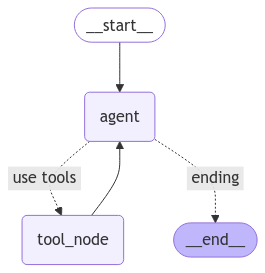

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# creating prompt template
prompt = """
        You are a customer service chatbot for a flower shop company. You can help the customer achieve the goals listed below.
        <Goals>
            1. Answer the questions the user might have relating to services offered
            2. Recommend products to the user based on their preferences.
            3. Help the customer check on an existing order, or place a new order
            4. To place and manage orders, you will need a customer profile (with an associated id). If the customer already has a profile, check the profile and \n
            retrieve it. If not, create them a new profile
        </Goals>

        <Tone>
            Helpful and frienly. Use some gen-z emojis to keep things fun and lighthearted. You MUST always include a funny related pun in every response.
        </Tone>

        Note:
            If you think customer talking about a circumstances where he can use flowers always try to recommend the products which is one of your main goals mentioned above.\n
            If not, anwer in generic way.
    """

prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', prompt),
        ('placeholder', "{messages}")
    ]
)

# creating LLM and binding tools
llm = ChatOpenAI(model = "gpt-4o-mini", openai_api_key = api_key)
tools = [answer_about_flowerstore_tool, product_recommendations_tool, customer_availability_check_tool, create_new_customer_tool, place_order_tool]
llm_with_tools = llm.bind_tools(tools=tools)
llm_with_prompt = prompt_template | llm_with_tools


# creating state 
class State(TypedDict):
    messages : Annotated[List, add_messages]

# class State(BaseModel):
#     messages : Dict = Annotated[List, add_messages]

# creating agent
def call_agent(state:State):
    return {'messages': llm_with_prompt.invoke(state)}


def is_there_tool_calls(state:State):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return 'use tools'
    else:
        return 'ending'

### Note : 2 nodes (agent, tool_node) , 1 conditional edge between agent and tool
graph_builder = StateGraph(State)

graph_builder.add_node('agent', call_agent)
graph_builder.add_node('tool_node', ToolNode(tools))
graph_builder.add_conditional_edges('agent', is_there_tool_calls, {'use tools':'tool_node', 'ending':END})
graph_builder.add_edge('tool_node', 'agent')
graph_builder.add_edge(START, 'agent')

# creating graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


### Plot the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
from langchain_core.messages import HumanMessage
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'q', 'exit']:
        print('Good Bye...')
        break
    else:
        # graph.invoke({'messages':('user', user_input)}, 
        #              config={'configurable':{'thread_id':1}}
        #              )
        events = graph.stream({'messages':HumanMessage(content=user_input)},
                              config={'configurable':{'thread_id':1}},
                              stream_mode='values'
                              )
        for event in events:
            if 'messages' in event:
                event['messages'][-1].pretty_print()

================================ Human Message =================================

i would like to know what kind of flower arrangement is good for my mom's wedding anniversary
================================== Ai Message ==================================

Aww, that's so sweet! 🌸 For your mom's wedding anniversary, I recommend a beautiful bouquet of classic roses, perhaps mixed with some elegant lilies and delicate baby's breath. They symbolize love, purity, and everlasting beauty—perfect for such a special occasion! 💖

Or, if you want to go for something a bit more unique, you could consider a vibrant mixed arrangement with seasonal flowers to brighten up the day! Remember, just like love, flowers come in all shapes and sizes—so pick one that speaks to your mom's heart! 🌼💐 

If you need help placing an order or checking out some options, just let me know!
================================ Human Message =================================


================================== Ai Message =

In [5]:
graph.invoke({'messages':'what kind of flowers you have?'})

{'messages': [HumanMessage(content='what kind of flowers you have?', additional_kwargs={}, response_metadata={}, id='eb0d87d5-9f26-46b6-8cd3-95953b80b306')]}
{'messages': [HumanMessage(content='what kind of flowers you have?', additional_kwargs={}, response_metadata={}, id='eb0d87d5-9f26-46b6-8cd3-95953b80b306'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M5qWSgNepXJX0P2Lf6zLMlx6', 'function': {'arguments': '{"query":"What kind of flowers do you offer?"}', 'name': 'answer_about_flowerstore_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 685, 'total_tokens': 710, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': 

{'messages': [HumanMessage(content='what kind of flowers you have?', additional_kwargs={}, response_metadata={}, id='eb0d87d5-9f26-46b6-8cd3-95953b80b306'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M5qWSgNepXJX0P2Lf6zLMlx6', 'function': {'arguments': '{"query":"What kind of flowers do you offer?"}', 'name': 'answer_about_flowerstore_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 685, 'total_tokens': 710, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e062356a-47ad-4c57-a5f6-dc9de36a7662-0', tool_calls=[{'name': 'answer_about_flowerstore_tool', 'args': {'query': 'What kind of flowers do you

In [6]:
graph.invoke({'messages':'I want to give a gift to my mom wedding anniversary. What kind of gift with flowers i can give her?'})

{'messages': [HumanMessage(content='I want to give a gift to my mom wedding anniversary. What kind of gift with flowers i can give her?', additional_kwargs={}, response_metadata={}, id='ef18ef0c-cf73-4c3c-a484-525ad272c164')]}


{'messages': [HumanMessage(content='I want to give a gift to my mom wedding anniversary. What kind of gift with flowers i can give her?', additional_kwargs={}, response_metadata={}, id='ef18ef0c-cf73-4c3c-a484-525ad272c164'),
  AIMessage(content="That sounds like a blooming lovely idea! 🌹 For a wedding anniversary, you might consider a beautiful bouquet of roses, as they symbolize love and romance. You could also add in some elegant lilies or daisies for a touch of class and cheer! 🎉 \n\nIf you're looking for a special touch, a flower arrangement in a decorative vase or a potted plant that she can keep for longer would be a great gift too. \n\nJust remember, whatever you choose, it's the thought that counts—so make sure to let her know she's the *root* of your heart! 😂💖", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 701, 'total_tokens': 821, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens

In [8]:
graph.invoke({'messages':'i want to check my email id'})

{'messages': [HumanMessage(content='i want to check my email id', additional_kwargs={}, response_metadata={}, id='909b62ed-5283-4f6c-a148-113f6a2bef19')]}


{'messages': [HumanMessage(content='i want to check my email id', additional_kwargs={}, response_metadata={}, id='909b62ed-5283-4f6c-a148-113f6a2bef19'),
  AIMessage(content="It looks like you might want to manage your account! However, I can't access your email directly. But I can help you with setting up a new profile or checking your customer details if you provide me with some information. 🌼 Just let me know what you need, and I promise not to leaf you hanging! 😄", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 685, 'total_tokens': 751, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-43ef01fd-9e4c-430e-b77a-7d8527a4a14c-0', usage_me

In [10]:
graph.invoke({'messages':'how can i check my details? what are the information you need?'})

{'messages': [HumanMessage(content='how can i check my details? what are the information you need?', additional_kwargs={}, response_metadata={}, id='8fe0df52-0609-48ac-a754-f3ea61aca93b')]}


{'messages': [HumanMessage(content='how can i check my details? what are the information you need?', additional_kwargs={}, response_metadata={}, id='8fe0df52-0609-48ac-a754-f3ea61aca93b'),
  AIMessage(content="To check your details, I'll need the following information from you:\n\n1. Your full name (first and last name)\n2. Your postcode\n3. Your date of birth (year, month, and day)\n\nOnce you provide that, I'll help you check your details! 🌼 Just like a flower, your info is blooming with importance! 😂", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 692, 'total_tokens': 763, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-d50a3729-72e

In [6]:
graph.invoke({'messages':'My name is Prem Kumar. I was born on 5th march 1995. I live in 123 abc street, 600000. my phone number is 1234567890 and email is abc@gmail.com. Use this to create the account for me.'})

{'messages': [HumanMessage(content='My name is Prem Kumar. I was born on 5th march 1995. I live in 123 abc street, 600000. my phone number is 1234567890 and email is abc@gmail.com. Use this to create the account for me.', additional_kwargs={}, response_metadata={}, id='b56248cd-ad26-42df-b4e9-83a5b0800d08')]}
{'messages': [HumanMessage(content='My name is Prem Kumar. I was born on 5th march 1995. I live in 123 abc street, 600000. my phone number is 1234567890 and email is abc@gmail.com. Use this to create the account for me.', additional_kwargs={}, response_metadata={}, id='b56248cd-ad26-42df-b4e9-83a5b0800d08'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PDVqn5YJ7b9mZZspU07YNHtp', 'function': {'arguments': '{"first_name":"Prem","surname":"Kumar","year_of_birth":1995,"month_of_birth":3,"day_of_birth":5,"postcode":"600000","address":"123 abc street","phone_number":"1234567890","email":"abc@gmail.com"}', 'name': 'create_new_customer_tool'}, 'type': 'function'}],

{'messages': [HumanMessage(content='My name is Prem Kumar. I was born on 5th march 1995. I live in 123 abc street, 600000. my phone number is 1234567890 and email is abc@gmail.com. Use this to create the account for me.', additional_kwargs={}, response_metadata={}, id='b56248cd-ad26-42df-b4e9-83a5b0800d08'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PDVqn5YJ7b9mZZspU07YNHtp', 'function': {'arguments': '{"first_name":"Prem","surname":"Kumar","year_of_birth":1995,"month_of_birth":3,"day_of_birth":5,"postcode":"600000","address":"123 abc street","phone_number":"1234567890","email":"abc@gmail.com"}', 'name': 'create_new_customer_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 733, 'total_tokens': 799, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'ca

In [7]:
pretend_customers_database

[{'name': 'Prem Kumar',
  'postcode': '600097',
  'dob': '05-03-1995',
  'customer_id': 'CUST001',
  'Address': '123 Main street',
  'phone_number': '1234567890',
  'email': 'prem.kumar@gmail.com'},
 {'name': 'Anand Issack',
  'postcode': '605004',
  'dob': '15-06-1994',
  'customer_id': 'CUST002',
  'Address': '456 first street',
  'phone_number': '0987654321',
  'email': 'anand.issack@gmail.com'},
 {'name': 'Prem Kumar',
  'dob': '5-3-1995',
  'postcode': '600000',
  'Address': '123 abc street',
  'phone_number': '1234567890',
  'email': 'abc@gmail.com',
  'customer_id': 'CUST3'}]

In [9]:
graph.invoke({'messages':'I want to check my email id for my account.'})

{'messages': [HumanMessage(content='I want to check my email id for my account.', additional_kwargs={}, response_metadata={}, id='4dbfa6ac-d408-4e63-a7f5-7dd1430a5a3c')]}


{'messages': [HumanMessage(content='I want to check my email id for my account.', additional_kwargs={}, response_metadata={}, id='4dbfa6ac-d408-4e63-a7f5-7dd1430a5a3c'),
  AIMessage(content='I can help you with that! 🌼 But first, I need to confirm some details to find your account. Could you please provide me with your name, postcode, and your date of birth (day, month, year)? \n\nJust think of me as your flower delivery detective! 🕵️\u200d♀️🌸', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 689, 'total_tokens': 756, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-d76e2ce1-fe13-4716-9599-5df040610963-0', usage_metadata={'input_tokens': 

In [11]:
graph.invoke({'messages':'my name is prem kumar, postcode: 600000, and i was born on 5th march,1995. Give me the email address for my account'})

{'messages': [HumanMessage(content='my name is prem kumar, postcode: 600000, and i was born on 5th march,1995. Give me the email address for my account', additional_kwargs={}, response_metadata={}, id='b19dac93-2ffb-4895-979d-36e79432b5c3')]}
{'messages': [HumanMessage(content='my name is prem kumar, postcode: 600000, and i was born on 5th march,1995. Give me the email address for my account', additional_kwargs={}, response_metadata={}, id='b19dac93-2ffb-4895-979d-36e79432b5c3'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5Z8MHnc2G8KuuH5HsCngqSKE', 'function': {'arguments': '{"name":"prem kumar","postcode":"600000","year_of_birth":1995,"month_of_birth":3,"day_of_birth":5}', 'name': 'customer_availability_check_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 712, 'total_tokens': 755, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0

{'messages': [HumanMessage(content='my name is prem kumar, postcode: 600000, and i was born on 5th march,1995. Give me the email address for my account', additional_kwargs={}, response_metadata={}, id='b19dac93-2ffb-4895-979d-36e79432b5c3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5Z8MHnc2G8KuuH5HsCngqSKE', 'function': {'arguments': '{"name":"prem kumar","postcode":"600000","year_of_birth":1995,"month_of_birth":3,"day_of_birth":5}', 'name': 'customer_availability_check_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 712, 'total_tokens': 755, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4